In [126]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import torch
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
import seaborn as sns
from tqdm import tqdm
from sophius.train import train_on_gpu_ex
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
])
cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=normalize)
cifar_gpu = dload.cifar_to_gpu(cifar10)

encoder = Encoder()

Files already downloaded and verified


In [128]:
from sophius.estimate import LSTMRegressor
from sophius.utils import calc_model_flops

estimator = torch.load('../data/models/estimator_v2.pth').cpu()

def estimate_acc(model_tmpl):
    t = torch.tensor(encoder.model2vec(model_tmpl), dtype=torch.float32)
    return estimator(t).item()

Conv2d       (32, 15, 15)   (4, 4)   (2, 2)  
PReLU        (32, 15, 15)  
MaxPool2d    (32, 5, 5)     (2, 2)   (3, 3)  
AvgPool2d    (32, 6, 6)     (4, 4)   (1, 1)  
GlobalAvgPool2d (32, 1, 1)    
Flatten      32            
Linear       10            

0.68 MFlops


Loss 78.366: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]

val_acc: 0.254 train_acc: 0.276
val_acc* 0.395


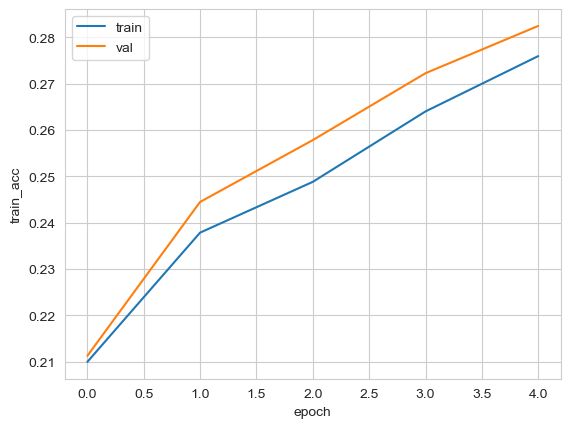

In [129]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), 
    out_shape=10, 
    conv_num=1, 
    lin_num=1,
)

model_tmpl = model_gen.generate_model_tmpl()
model = model_tmpl.instantiate_model().cuda()

print(model_tmpl)
flops = calc_model_flops(model, model_gen.in_shape)['flops']
print(round(flops / 1024 / 1024, 2), 'MFlops')

train_params = {
    'val_size': 10000,
    'batch_size': 1024,
    'num_epoch': 5,
    'random_seed':42,
    'optimizer': 'AdamW',
    'opt_params': {
        'lr': 1e-3,
    },
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },
}

res = train_on_gpu_ex(
    model=model,
    dataset=cifar_gpu,
    verbose=True,
    **train_params,
)
print('val_acc* %.3f' % (estimate_acc(model_tmpl)))

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val');

In [130]:
import torch
torch.cuda.get_device_name()

'NVIDIA RTX A500 Laptop GPU'

In [131]:
from sophius.db import *
from peewee import *

with database:
    database.create_tables([Experiments, Models, Devices, Runs, ModelEpochs])    

In [132]:
exp_params = {**train_params, **{'in_shape': (3, 32, 32), 'out_shape': 10}}

exp, _ = Experiments.get_or_create(**exp_params)
print(exp)
    
Devices.create_table()
dev, _ = Devices.get_or_create(name=torch.cuda.get_device_name())
print(dev)

1
1


In [133]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), out_shape=10, 
    conv_num=1, lin_num=1
)

val_acc_threshold = 0.05

for i in tqdm(range(10)):
    model_tmpl = model_gen.generate_model_tmpl()
    model_gpu = model_tmpl.instantiate_model().cuda()
    
    if estimate_acc(model_tmpl) < val_acc_threshold:
        continue
    
    model_info = calc_model_flops(model_gpu, model_gen.in_shape)        
    model, _ = Models.get_or_create(
        hash = encoder.model2hash(model_tmpl),
        flops = model_info['flops'],
        macs = model_info['macs'],
        params = model_info['params'],        
    )
        
    epoch_results = train_on_gpu_ex(
        model=model_gpu,
        dataset=cifar_gpu,
        verbose=False,
        **train_params,
    )
    
    run = Runs.create(
        exp_id = exp.id,
        model_id = model.id,
        device_id = dev.id,
        val_acc = round(epoch_results.val_acc.iloc[-10:].mean(), 4),
        train_acc = round(epoch_results.train_acc.iloc[-10:].mean(), 4),
        time = round(epoch_results.time.iloc[-1], 2),
    )
    
    
    for _, row in epoch_results.iterrows():
        ModelEpochs.create(
            exp_id = exp.id,
            run_id = run.id,
            epoch = row['epoch'],
            loss = row['loss'],
            train_acc = row['train_acc'],
            val_acc = row['val_acc'],
            time = row['time'],
        )    

100%|██████████| 10/10 [07:54<00:00, 47.41s/it]


In [137]:
import pandas as pd

query = (Runs
         .select(Runs.id.alias('run_id'), Runs, Models, Devices.name.alias('dev_name'))
         .join(Models)
         .switch(Runs)
         .join(Devices)
         .dicts())

cols = ['run_id', 'hash', 'flops', 'params', 'val_acc', 'train_acc', 'time', 'dev_name']
df = pd.DataFrame(query)[cols]
# df = pd.DataFrame(query)

df[-5:]

,run_id,hash,flops,params,val_acc,train_acc,time,dev_name
15,16,00802222100800000048a00001000000,21809472,564298,0.5602,0.5915,342.55,NVIDIA RTX A500 Laptop GPU
16,17,008108221002000000429000400000000024d00001000000,2006912,41930,0.5971,0.6084,14.90,NVIDIA RTX A500 Laptop GPU
17,18,0084080910040000400000000022d0000010000001000000,57040,410,0.2228,0.2148,0.98,NVIDIA RTX A500 Laptop GPU
18,19,00811005100800000010000001000000,38144,906,0.2067,0.1985,0.99,NVIDIA RTX A500 Laptop GPU
19,20,008082091004000000486000002350000010000001000000,956256,5674,0.2563,0.2543,2.67,NVIDIA RTX A500 Laptop GPU


In [135]:
with database.connection() as conn:
    exp = pd.read_sql('SELECT * from experiments', conn)
exp

,id,val_size,batch_size,num_epoch,random_seed,optimizer,opt_params,scheduler,sch_params,in_shape,out_shape
0,1,10000,1024,5,42,AdamW,"{""lr"":0.001}",ExponentialLR,"{""gamma"":0.95}","(3, 32, 32)",10


In [138]:
encoder.hash2model('00802222100800000048a00001000000', (3, 32, 32), 10)

Conv2d       (192, 33, 33)  (4, 4)   (1, 1)  
LeakyReLU    (192, 33, 33)  (0.1)   
MaxPool2d    (192, 17, 17)  (2, 2)   (2, 2)  
Flatten      55488         
Linear       10            